# Hyperopt



In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing
from sklearn.metrics import roc_auc_score

In [57]:
## we start again by reading our data

eye_movements = pd.read_csv("../data/eye_movements_aggregated.csv")
eye_movements.head()

,titleNo,assgNo,fixcount,firstPassCnt,P1stFixation,P2stFixation,prevFixDur,firstfixDur,firstPassFixDur,nextFixDur,...,totalFixDur,meanFixDur,nRegressFrom,regressLen,nextWordRegress,regressDur,pupilDiamMax,pupilDiamLag,timePrtctg,target
0,1,1,1.0,1.0,1.0,0.0,166.80,194.800000,194.800000,190.80,...,194.800000,194.800000,0.0,0.0,0.000000,0.0,0.053500,0.185700,0.025460,0
1,1,10,1.0,1.0,1.0,0.0,159.25,209.000000,209.000000,228.75,...,209.000000,209.000000,0.0,0.0,0.000000,0.0,-0.010225,0.049650,0.035775,0
2,1,100,1.0,1.0,1.0,0.0,139.00,165.666667,165.666667,192.00,...,165.666667,165.666667,0.0,0.0,0.333333,0.0,0.098000,0.178500,0.022467,0
3,1,101,2.0,2.0,1.0,0.0,109.50,139.000000,219.000000,109.50,...,219.000000,119.333350,0.0,0.0,0.000000,0.0,0.203750,0.554500,0.056500,0
4,1,102,1.0,1.0,1.0,0.0,109.00,114.000000,114.000000,119.00,...,114.000000,114.000000,0.0,0.0,0.000000,0.0,0.132250,0.266125,0.020350,0


In [58]:
eye_movements.shape

(2664, 25)

In [59]:
eye_features = eye_movements.loc[:,['fixcount', 'firstPassCnt', 'P1stFixation', 'P2stFixation',
       'prevFixDur', 'firstfixDur', 'firstPassFixDur', 'nextFixDur',
       'firstSaccLen', 'lastSaccLen', 'prevFixPos', 'landingPos', 'leavingPos',
       'totalFixDur', 'meanFixDur', 'nRegressFrom', 'regressLen',
       'nextWordRegress', 'regressDur', 'pupilDiamMax', 'pupilDiamLag',
       'timePrtctg']]
labels = eye_movements['target'].astype(int)

In [60]:
##let's start by splitting the data into a train and a validation set
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(eye_features, labels, test_size=0.2, random_state=123)


we train a model to gain an idea of baseline performance 

In [61]:
%%time 
import xgboost as xgb
xgb_model = xgb.XGBClassifier(n_jobs=multiprocessing.cpu_count()-2)

xgb_model.fit(X_train, y_train)

CPU times: user 3.18 s, sys: 3.96 ms, total: 3.18 s
Wall time: 553 ms


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=6,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [62]:
print( 'train st performance:',roc_auc_score(y_train , xgb_model.predict_proba( X_train ) , multi_class='ovr' ) )
print( 'valid set performance:',roc_auc_score(y_valid , xgb_model.predict_proba( X_valid ) , multi_class='ovr') )

train st performance: 1.0
valid set performance: 0.7498756501657234


# "basic" usage 

In [63]:
from hyperopt import hp, fmin, tpe, rand, pyll, STATUS_OK, STATUS_FAIL, Trials, space_eval

## function to optimize

We need to write a function which :
 * takes a dictionary of parameters as arguments
 * returns a dictionnary containing the computed loss and a status value
 
Importantly, the loss is a value which we want to **minimize**, so in our case we will
use -AUC(validation data)

In [64]:

def hyperopt_xgb_train( params ):
    
    xgb_model = xgb.XGBClassifier(n_jobs=multiprocessing.cpu_count()-2 , **params)
    xgb_model.fit(X_train, y_train)
    
    loss = -roc_auc_score(y_valid , xgb_model.predict_proba( X_valid ) , multi_class='ovr' )
    return_dict = {'loss': loss,
                   'status': STATUS_OK
                   }
    return return_dict


In [65]:
params = dict( n_estimators=100,
               eta = 0.3,
               subsample = 0.8,
               max_depth = 5)
hyperopt_xgb_train( params )

{'loss': -0.7537885939813355, 'status': 'ok'}

## parameter search-space

The way it works is that for each hyper-parameter you define a **prior distribution** (it is bayesian afterall) using one of hyperopt function.

For a more detailed documentation we refer you to the [hyperopt documentation](http://hyperopt.github.io/hyperopt/getting-started/search_spaces/)

In [67]:
simple_uniform = hp.uniform('simple', 0, 1)
simple_uniform

In [68]:
pyll.stochastic.sample(simple_uniform)

0.8397901851015662

In [70]:
eta = hp.loguniform('eta' , np.log(10**-4) , np.log(10**2) )
pyll.stochastic.sample(eta)

0.0006056840781801796

<Axes: ylabel='Count'>

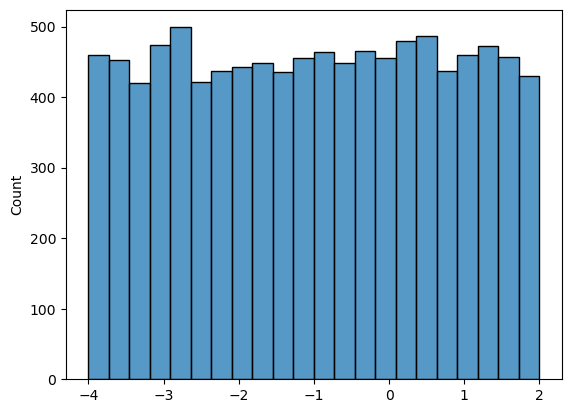

In [71]:
sns.histplot( [ np.log10( pyll.stochastic.sample(eta) ) for _ in range(10000) ] )

**exercise** : which prior distribution could we give `n_estimators`? to `max_depth` ? 

In [75]:
## proposed parameter space
# %load solutions/solution_hyperopt_parameter_space.py

## minimizing

In [76]:
%%time
trials = Trials()

best = fmin(hyperopt_xgb_train, 
            space4xgb, 
            algo=tpe.suggest, 
            max_evals=10, 
            trials=trials)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.29trial/s, best loss: -0.7634330042688159]
CPU times: user 46 s, sys: 220 ms, total: 46.2 s
Wall time: 7.74 s


In [77]:
best

{'eta': 0.019747464671523208,
 'max_depth': 4.0,
 'n_estimators': 683.0,
 'subsample': 0.6816867727385938}

In [78]:
len( trials )

10

In [79]:
trials.trials

[{'state': 2,
  'tid': 0,
  'spec': None,
  'result': {'loss': -0.7388087059435741, 'status': 'ok'},
  'misc': {'tid': 0,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'eta': [0],
    'max_depth': [0],
    'n_estimators': [0],
    'subsample': [0]},
   'vals': {'eta': [1.2974324699909743],
    'max_depth': [12.0],
    'n_estimators': [261.0],
    'subsample': [0.789030157569486]}},
  'exp_key': None,
  'owner': None,
  'version': 0,
  'book_time': datetime.datetime(2024, 10, 9, 13, 5, 9, 93000),
  'refresh_time': datetime.datetime(2024, 10, 9, 13, 5, 9, 662000)},
 {'state': 2,
  'tid': 1,
  'spec': None,
  'result': {'loss': -0.7291562298941692, 'status': 'ok'},
  'misc': {'tid': 1,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'eta': [1],
    'max_depth': [1],
    'n_estimators': [1],
    'subsample': [1]},
   'vals': {'eta': [0.543617401495742],
    'max_depth': [16.0],
    'n_estimators': [230.0],
    'subsa

In [80]:
trials.results[:10]

[{'loss': -0.7388087059435741, 'status': 'ok'},
 {'loss': -0.7291562298941692, 'status': 'ok'},
 {'loss': -0.7253603316837104, 'status': 'ok'},
 {'loss': -0.5177099495500145, 'status': 'ok'},
 {'loss': -0.5734500417344474, 'status': 'ok'},
 {'loss': -0.7178259259704394, 'status': 'ok'},
 {'loss': -0.5594464028772695, 'status': 'ok'},
 {'loss': -0.7634330042688159, 'status': 'ok'},
 {'loss': -0.7309415831758562, 'status': 'ok'},
 {'loss': -0.5077782453636198, 'status': 'ok'}]

In [81]:
trials.losses()[:10]

[-0.7388087059435741,
 -0.7291562298941692,
 -0.7253603316837104,
 -0.5177099495500145,
 -0.5734500417344474,
 -0.7178259259704394,
 -0.5594464028772695,
 -0.7634330042688159,
 -0.7309415831758562,
 -0.5077782453636198]

In [82]:
trials.vals.keys()

dict_keys(['eta', 'max_depth', 'n_estimators', 'subsample'])

In [83]:
for k in trials.vals.keys():
    print(k , trials.vals[k][:5])

eta [1.2974324699909743, 0.543617401495742, 0.0009974898987830784, 2.6989823508547905, 8.022223521592775]
max_depth [12.0, 16.0, 2.0, 9.0, 12.0]
n_estimators [261.0, 230.0, 764.0, 53.0, 44.0]
subsample [0.789030157569486, 0.858408637742043, 0.47486304280862246, 0.9954825857592089, 0.7684667979200643]


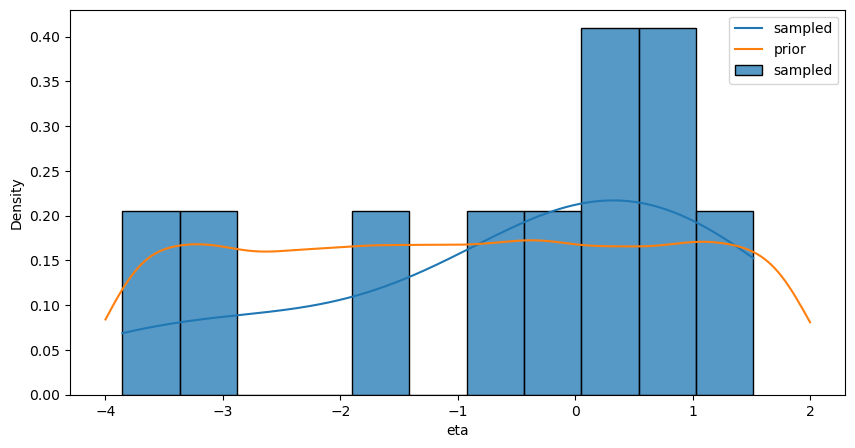

In [84]:
fig,ax = plt.subplots(figsize=(10,5))

sns.kdeplot( np.log10( trials.vals['eta'] ) , ax=ax , cut = 0 , label='sampled')
sns.histplot( np.log10( trials.vals['eta'] ) , binwidth=0.5 , ax=ax , label='sampled' , stat = 'density')

sns.kdeplot( [ np.log10( pyll.stochastic.sample(eta) ) for _ in range(10000) ] , ax=ax , cut = 0 , label='prior')
ax.set_xlabel('eta')
ax.legend()

Text(0, 0.5, 'loss')

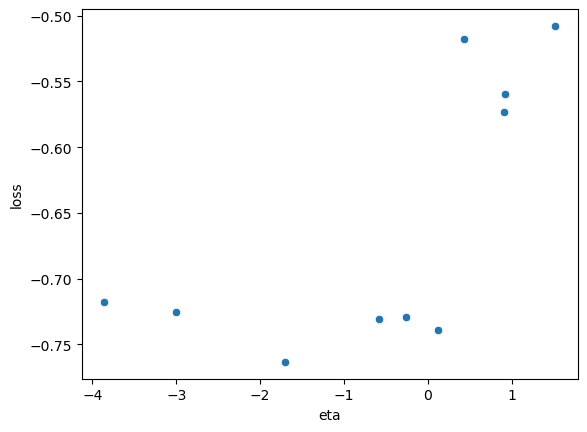

In [85]:

ax = sns.scatterplot( x = np.log10( trials.vals['eta'] ) ,
                 y =  trials.losses() )
ax.set_xlabel('eta')
ax.set_ylabel('loss')

Text(0, 0.5, 'loss')

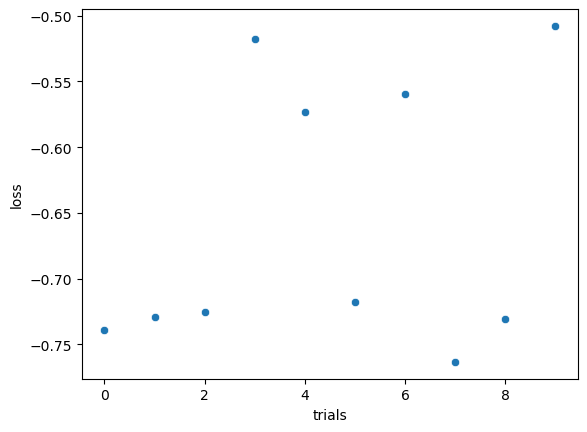

In [86]:
ax = sns.scatterplot( x =  range(len(trials.losses())) ,  y =  trials.losses() )
ax.set_xlabel('trials')
ax.set_ylabel('loss')

# changing the cross-validation scheme

In [87]:
from sklearn.model_selection import StratifiedKFold

In [88]:
skf = StratifiedKFold(n_splits=5 , shuffle=True , random_state = 2024 )
for t,v in skf.split( eye_features, labels ):

    print(len(t), t[:5])
    print(len(v), v[:5])

2131 [1 2 3 4 5]
533 [ 0 11 12 17 18]
2131 [0 1 3 5 6]
533 [ 2  4 16 25 26]
2131 [0 1 2 3 4]
533 [ 6  8 13 21 24]
2131 [0 2 3 4 6]
533 [ 1  5  7 10 14]
2132 [0 1 2 4 5]
532 [ 3  9 20 32 54]


In [89]:
from sklearn.model_selection import cross_val_score
cross_val_score( xgb.XGBClassifier(n_jobs=multiprocessing.cpu_count()-2) , 
                eye_features, labels, scoring = 'roc_auc_ovr' , cv = skf )

array([0.75040452, 0.74499737, 0.76594438, 0.75008174, 0.74560265])

### exercise

Write the function we will give to `fmin` to evaluate an XGBoost classifier with 5-fold CV with a ROC AUC score.


In [90]:
## tentative solution
def hyperopt_xgb_train_CV5( params ):
    
    losses = -1 * cross_val_score( xgb.XGBClassifier(n_jobs=multiprocessing.cpu_count()-2 , **params) , 
                eye_features, labels, scoring = 'roc_auc_ovr' , cv = skf )
        
    return_dict = {'loss': np.mean(losses),
                   'loss_variance' : np.var(losses),
                   'status': STATUS_OK
                   }
    return return_dict


In [91]:
params = dict( n_estimators=100,
               eta = 0.3,
               subsample = 0.8,
               max_depth = 5)
hyperopt_xgb_train_CV5( params )

{'loss': -0.7510766126017809,
 'loss_variance': 1.0129111084212657e-05,
 'status': 'ok'}

In [92]:
%%time
trials = Trials()

best = fmin(hyperopt_xgb_train_CV5, 
            space4xgb, 
            algo=tpe.suggest, 
            max_evals=10, 
            trials=trials)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:03<00:00, 24.30s/trial, best loss: -0.7637962039217782]
CPU times: user 24min 2s, sys: 3.67 s, total: 24min 5s
Wall time: 4min 3s


# warm start : continue searching for better solutions

In [39]:
best = fmin(hyperopt_xgb_train_CV5, 
            space4xgb, 
            algo=tpe.suggest, 
            max_evals=12, 
            trials=trials)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:50<00:00, 17.06s/trial, best loss: -0.7714936180275178]


# nested search space

It is possible nest elements in `hp.choice()` or `hp.pchoice()` to specify more complex search spaces:

In [40]:
space4nested = hp.pchoice('classifier_type',
                          [(0.6, {'classifier_type': 'xgboost',
                                    'n_estimators': pyll.scope.int(hp.quniform('n_estimators', 1 , 1000,1)),
                                    'eta': hp.loguniform('eta' , np.log(10**-4) , np.log(10**2) ),
                                    'max_depth': pyll.scope.int(hp.quniform('max_depth', 1, 16, 1)),
                                    'subsample': hp.uniform('subsample', 0.3, 1)
                                  }
                            ),
                           (0.4, {'classifier_type': 'logistic regression',
                                  'C': hp.loguniform("C", low=np.log(1e-5), high=np.log(1e2)),
                                  'penalty': hp.choice('penalty', ['l1','l2'])
                                  }
                            )]
                          )

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


def hyperopt_complex_train_CV5( params ):
    
    classif_type = params.pop('classifier_type')
    
    model = None
    if classif_type == 'xgboost':
        model = xgb.XGBClassifier(n_jobs=multiprocessing.cpu_count()-2 , **params) 
    
    else:
        model =Pipeline([('scalar',StandardScaler()), 
                      ('model',LogisticRegression(solver ='liblinear', class_weight='balanced', **params))])
    
    losses = -1 * cross_val_score( model  , 
                    eye_features, labels, scoring = 'roc_auc_ovr' , cv = skf )
        
    return_dict = {'loss': np.mean(losses),
                   'loss_variance' : np.var(losses),
                   'status': STATUS_OK
                   }
    return return_dict


In [44]:
%%time
trials = Trials()
best = fmin(hyperopt_complex_train_CV5, 
            space4nested, 
            algo=tpe.suggest, 
            max_evals=15, 
            trials=trials)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [02:14<00:00,  8.97s/trial, best loss: -0.7639579442698732]
CPU times: user 13min 1s, sys: 2.38 s, total: 13min 3s
Wall time: 2min 14s


In [51]:
trials.trials

[{'state': 2,
  'tid': 0,
  'spec': None,
  'result': {'loss': -0.7248186999309988,
   'loss_variance': 0.00011667586084578778,
   'status': 'ok'},
  'misc': {'tid': 0,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'C': [0],
    'classifier_type': [0],
    'eta': [],
    'max_depth': [],
    'n_estimators': [],
    'penalty': [0],
    'subsample': []},
   'vals': {'C': [2.7557546161390567],
    'classifier_type': [1],
    'eta': [],
    'max_depth': [],
    'n_estimators': [],
    'penalty': [1],
    'subsample': []}},
  'exp_key': None,
  'owner': None,
  'version': 0,
  'book_time': datetime.datetime(2024, 10, 9, 12, 14, 55, 176000),
  'refresh_time': datetime.datetime(2024, 10, 9, 12, 14, 55, 335000)},
 {'state': 2,
  'tid': 1,
  'spec': None,
  'result': {'loss': -0.680161851239831,
   'loss_variance': 3.3164214443651106e-05,
   'status': 'ok'},
  'misc': {'tid': 1,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idx

Text(0, 0.5, 'loss')

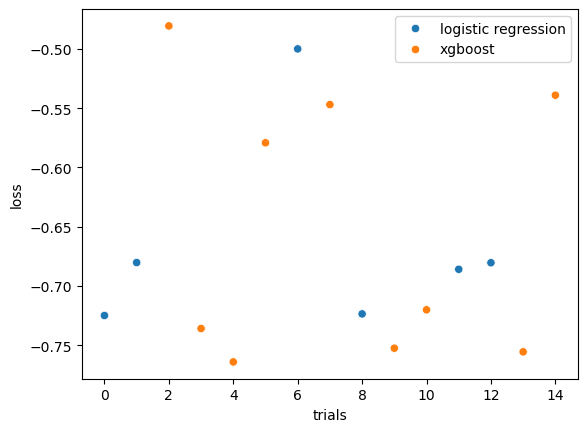

In [45]:
ax = sns.scatterplot( x =  range(len(trials.losses())) ,  y =  trials.losses() , 
                     hue = np.array(['xgboost','logistic regression'])[trials.vals['classifier_type']] )
ax.set_xlabel('trials')
ax.set_ylabel('loss')